## Set environment

In [1]:
import numpy as np
import pandas as pd
import io
import esm
import argparse
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import open_close_scan
char_map = {'A': 'T',
            'G': 'C',
            'C': 'G',
            'T': 'A',}
value_map = {'A': 0,'C':1,'G':2,'T':3}
window_size = 20

C:\Users\hmxy1\.conda\envs\ai\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load data

In [2]:
sseq_GENE = None
sscount_file = 'D:/CODE/BIO/dataset/ASO/STAT3/sscount.txt' # ss-count result from mFold
statistic_save = 'D:/CODE/BIO/dataset/ASO/results/STAT3_before.csv'
filter_save = 'D:/CODE/BIO/dataset/ASO/results/STAT3_after.csv'

with open(sscount_file, 'r') as fp:
    cnt = fp.readline()
    data = fp.readlines()
    print('read {} lines from sscount file'.format(len(data)))
    value = []
    sequence = []
    for line in data:
        sp = line.split()
        value.append(int(sp[1])/int(cnt))
        if sp[2] == 'U':
            sp[2] = 'T'
        sequence.append(sp[2])
    sseq_GENE = open_close_scan.Seq(sequence, value)
sseq_GENE.open_threshold = 0.5

read 4973 lines from sscount file


In [3]:
input_file = 'D:/CODE/BIO/dataset/ASO/STAT3/data.csv'
df = pd.read_csv(input_file)
df.columns = ['seq','inhibition','nm']
df = df[['seq','inhibition','nm']]
df.head()

,seq,inhibition,nm
0,CGCAGCTCCGGAAACC,12,0
1,CCGCAGCTCCGGAAAC,11,0
2,CGCCGCAGCTCCGGAA,10,0
3,CCGCCGCAGCTCCGGA,22,0
4,ACCCCCGGCTCCCCCT,18,0


## Feature definition
GENE_pos : Start position of the ASO on mRNA GENE. If ASO can not match with GENE, the value is -1.

GENE_open_ratio : Open ratio of the area that ASO matched with GENE. -1 if unmatched.

GENE_open_len : Max length of contiguous 'open' bp of the area. -1 if unmatched.

cg_ratio : percentage of CG

posi : number of 'positive' special subsequence

nega : number of 'negative' special subsequence


In [4]:
class FeatureCalc:
    @staticmethod
    def match_pos(df,seq:open_close_scan.Seq):
        rev_str = open_close_scan.get_ASO(df['seq'])
        # print(seq.str)
        # print(rev_str)
        start = seq.str.find(rev_str)
        return start
    
    @staticmethod
    def match_open_ratio(df,col,seq:open_close_scan.Seq):
        if df[col]>=0:
            st = df[col]
            ed = st + len(df['seq'])
            open_ratio = np.sum(seq.value[st:ed] >= seq.open_threshold) / (ed-st)
            return open_ratio
        else:
            return -1
    @staticmethod
    def match_open_len(df,col,seq:open_close_scan.Seq):
        if df[col]>=0:
            st = df[col]
            ed = st + len(df['seq'])
            open_len = seq.calc_contiguous_opening_len(st,ed)
            return open_len
        else:
            return -1
    pass

In [5]:
def check_cg_ratio(df):
    cnt = 0
    for ch in df['seq']:
        if (ch =='C') or (ch=='G'):
            cnt += 1
    return cnt / len(df['seq'])

def check_tm(df):
    cnt = 0
    for ch in df['seq']:
        if (ch =='C') or (ch=='G'):
            cnt += 1
    Tm = 4 * cnt + 2 * (len(df['seq']) - cnt)
    return Tm

def check_subword(df,_esm):
    cnt = len(_esm.query(df['seq']))
    return cnt

def get_value(df,k):
    return value_map[df['seq'][k]]

def get_base_count(df,target):
    cnt = 0
    for ch in df['seq']:
        cnt += (ch == target)
    return cnt

def pre_process(df):
    # for i in range(window_size):
    #     df.loc[:,'loc'+str(i)] = df.apply(get_value,k=i,axis=1)
    for key in value_map.keys():
        df.loc[:,'num_'+str(key)] = df.apply(get_base_count,target=key,axis=1)
    df.loc[:,'cg_ratio'] = df.apply(check_cg_ratio,axis=1)
    df.loc[:,'tm'] = df.apply(check_tm,axis=1)
    #
    df.loc[:,'GENE_pos'] = df.apply(FeatureCalc.match_pos,seq=sseq_GENE,axis=1)
    df.loc[:,'GENE_open_ratio'] = df.apply(FeatureCalc.match_open_ratio,seq=sseq_GENE,col='GENE_pos',axis=1)
    df.loc[:,'GENE_open_len'] = df.apply(FeatureCalc.match_open_len,seq=sseq_GENE,col='GENE_pos',axis=1)
    #initialize esm
    POSITIVE_SEQ = ['CCAC', 'TCCC', 'ACTC', 'GCCA', 'CTCT']
    NEGATIVE_SEQ = ['GGGG', 'ACTG', 'TAA', 'CCGG', 'AAA']
    positive_index = esm.Index()
    for word in POSITIVE_SEQ:
        positive_index.enter(word)
    positive_index.fix()
    negative_index = esm.Index()
    for word in NEGATIVE_SEQ:
        negative_index.enter(word)
    negative_index.fix()
    df.loc[:,'posi'] = df.apply(check_subword,_esm=positive_index,axis=1)
    df.loc[:,'nega'] = df.apply(check_subword,_esm=negative_index,axis=1)
    #
    return df


## Data prepare

In [6]:
def k_fold(k,id,data,index=None):
    size = df.shape[0]
    block = size//k
    if index is None:
        index = list(range(0,size))
    train_idx = index[0:id*block] + index[(id+1)*block:]
    test_idx = index[id*block:(id+1)*block]
    train = data.loc[train_idx]
    test = data.loc[test_idx]
    return train,test

In [7]:
df = pre_process(df)
x_column = []
for i in range(6,16):
    x_column.append('loc'+str(i))
print(df.head())
df.to_csv('debug.csv')

                seq  inhibition  nm  num_A  num_C  num_G  num_T  cg_ratio  tm  \
0  CGCAGCTCCGGAAACC          12   0      4      7      4      1    0.6875  54   
1  CCGCAGCTCCGGAAAC          11   0      4      7      4      1    0.6875  54   
2  CGCCGCAGCTCCGGAA          10   0      3      7      5      1    0.7500  56   
3  CCGCCGCAGCTCCGGA          22   0      2      8      5      1    0.8125  58   
4  ACCCCCGGCTCCCCCT          18   0      1     11      2      2    0.8125  58   

   GENE_pos  GENE_open_ratio  GENE_open_len  posi  nega  
0         0            0.375              5     0     2  
1         1            0.375              4     0     2  
2         3            0.250              2     0     1  
3         4            0.250              1     0     1  
4        31            0.125              1     1     1  


## feature checking

Box plot of inhibiton grouped by 'nm'.

We can see that '100nm' group have higher average inhibiton

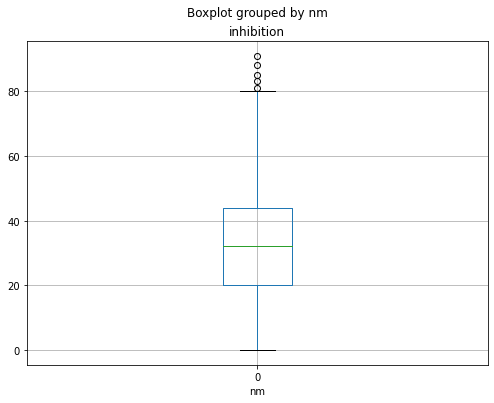

In [8]:
df_tmp = pd.DataFrame(df[['nm','inhibition']])
df_tmp.boxplot('inhibition',by='nm',figsize=(8,6))
plt.show()

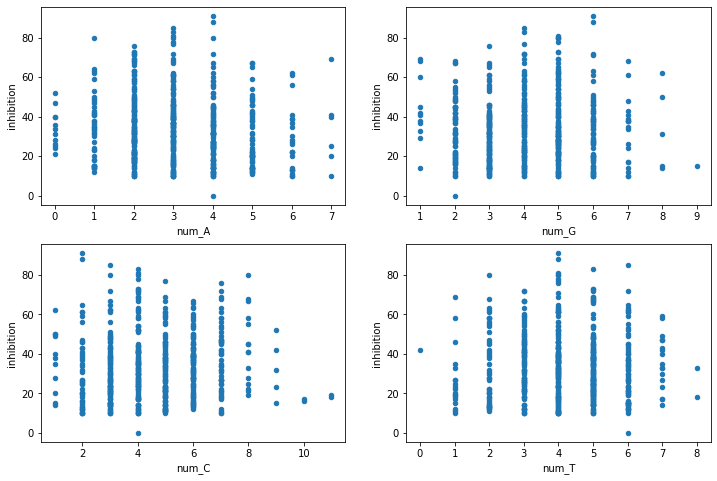

In [9]:
fig,axes = plt.subplots(2,2,figsize=(12,8))
df.plot.scatter(x='num_A',y='inhibition',ax=axes[0,0])
df.plot.scatter(x='num_G',y='inhibition',ax=axes[0,1])
df.plot.scatter(x='num_C',y='inhibition',ax=axes[1,0])
df.plot.scatter(x='num_T',y='inhibition',ax=axes[1,1])
plt.show()

### CG_Ratio
关于"CG碱基对所占比例","Tm temperature"和inhibition关系的散点图

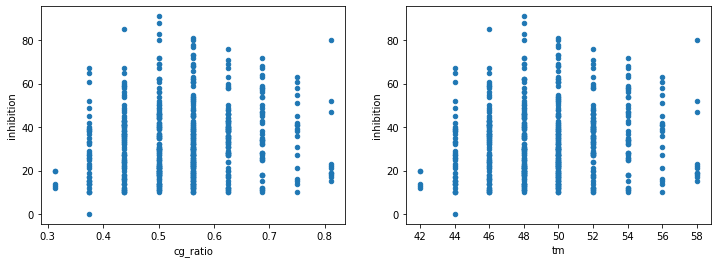

In [10]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
df_tmp = pd.DataFrame(df)
df_tmp.plot.scatter(x='cg_ratio',y='inhibition',ax=axes[0])
df_tmp.plot.scatter(x='tm',y='inhibition',ax=axes[1])
plt.show()

In [11]:
df_tmp = pd.DataFrame(df)

plt.show()

### Special subsequence

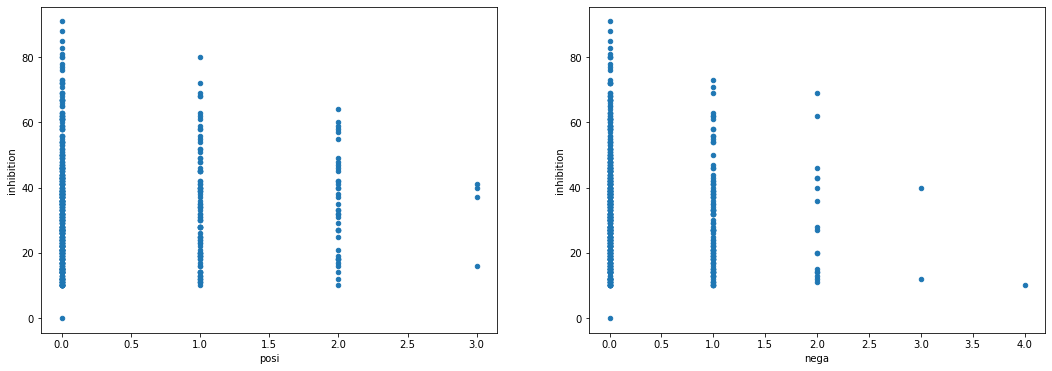

In [12]:
fig,axes = plt.subplots(1,2,figsize=(18,6))
df_tmp = pd.DataFrame(df)
df_tmp.plot.scatter(x='posi',y='inhibition',ax=axes[0])
df_tmp.plot.scatter(x='nega',y='inhibition',ax=axes[1])
plt.show()

### Feature on GENE
position, open ratio, open len

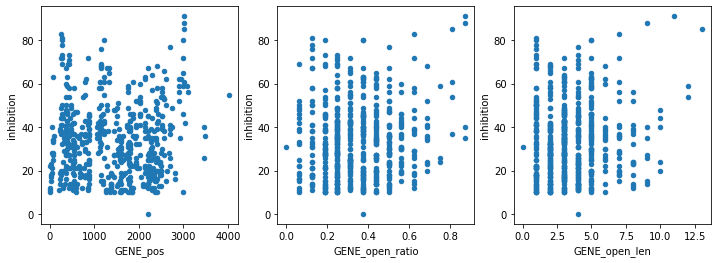

In [13]:
fig,axes = plt.subplots(1,3,figsize=(12,4))
df_tmp = pd.DataFrame(df[df['GENE_pos']>-1])
df_tmp.plot.scatter(x='GENE_pos',y='inhibition',ax=axes[0])
df_tmp.plot.scatter(x='GENE_open_ratio',y='inhibition',ax=axes[1])
df_tmp.plot.scatter(x='GENE_open_len',y='inhibition',ax=axes[2])
plt.show()

### try filt

Try filting all data that:(matches with GENE sequence, higher open ratio, higner open len)
The result is following.


C:\Users\hmxy1\AppData\Local\Temp\ipykernel_15112\3049180243.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp1 = df_tmp1[df_tmp['GENE_open_len']>=4]
C:\Users\hmxy1\AppData\Local\Temp\ipykernel_15112\3049180243.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp1 = df_tmp1[df_tmp['cg_ratio']>=0.4]


{'whiskers': [<matplotlib.lines.Line2D at 0x2d0fb542820>,
 'caps': [<matplotlib.lines.Line2D at 0x2d0fb542dc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d0fb542550>,
 'medians': [<matplotlib.lines.Line2D at 0x2d0fa1893a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2d0fa189670>,
 'means': []}

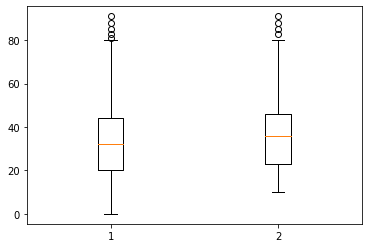

In [14]:
fig,axes = plt.subplots(1,1,figsize=(6,4))
df_tmp = pd.DataFrame(df[df['GENE_pos']>-1])
df_tmp1 = df_tmp[df_tmp['GENE_open_ratio']>0.3]
df_tmp1 = df_tmp1[df_tmp['GENE_open_len']>=4]
df_tmp1 = df_tmp1[df_tmp['cg_ratio']>=0.4]
# df_tmp.plot.scatter(x='cg_ratio',y='inhibition',ax=axes[0])
# df_tmp1.plot.scatter(x='cg_ratio',y='inhibition',ax=axes[1])
# df_tmp.boxplot('inhibition',ax=axes[0])
# df_tmp1.boxplot('inhibition',ax=axes[1])
data=[df_tmp['inhibition'],df_tmp1['inhibition']]
axes.boxplot(data)
# plt.show()


In [15]:
df_tmp.to_csv(statistic_save)
df_tmp1.to_csv(filter_save)

In [16]:
# fig,axes = plt.subplots(1,2,figsize=(18,6))
# df_tmp = pd.DataFrame(df_tmp1)
# df_tmp.plot.scatter(x='posi',y='inhibition',ax=axes[0])
# df_tmp.plot.scatter(x='nega',y='inhibition',ax=axes[1])
# plt.show()

### ttest & KS test

In [17]:
import scipy.stats as stats
print(stats.ttest_ind(data[0],data[1]))
print(stats.ks_2samp(data[0],data[1]))

Ttest_indResult(statistic=-1.6703145917843638, pvalue=0.09529115243857171)
KstestResult(statistic=0.07481058682537425, pvalue=0.40656902611663415)


<AxesSubplot:>

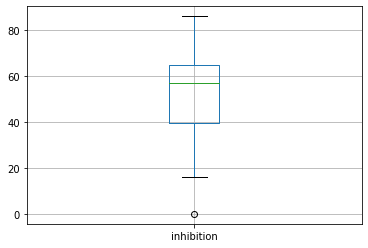

In [36]:
df_tmp1.boxplot('inhibition')


In [37]:
# find the ones passed filter but have low inhibition
print(df_tmp[df_tmp['inhibition']<25])

                     seq  inhibition  nm  num_A  num_C  num_G  num_T  \
10  TCTTTGGCGGTGCACACGCC           0   0      2      7      6      5   
11  GCACCATCTTTGGCGGTGCA           0   0      3      6      6      5   
12  GCAGGGAGCACCATCTTTGG          16   0      4      5      7      4   
14  CCACCGAAGATGCAGGGAGC           0   0      6      6      7      1   
24  TTCAAGTTCCAGTCTAATGA          10   0      6      4      3      7   
47  CATTGAAATATCAAAGCATT           0   0      9      3      2      6   
49  AATTGAGGCTAACATTGAAA           1   0      9      2      4      5   
51  TATGGTGTTCAGAAATTGAG          13   0      6      1      6      7   
54  GACAAGCTTTACATTCTACC          24   0      6      6      2      6   
72  TGAGGCTACCACATTTCCTA           0   0      5      6      3      6   
76  TCATATCAAAGTAGAAACAA          12   0     11      3      2      4   
77  TCCGAAAAACAGTCATATCA          24   0      9      5      2      4   

    cg_ratio  tm  GENE_pos  GENE_open_ratio  GENE_open_len  pos

### Pearson Correlation
following are Pearson correlation of each attribute with 'inhibiton'

In [38]:
print(df.corrwith(df['inhibition']))

inhibition         1.000000
nm                      NaN
num_A             -0.102978
num_C              0.112173
num_G             -0.043269
num_T              0.034503
cg_ratio           0.043451
tm                 0.043451
GENE_pos           0.104648
GENE_open_ratio    0.106651
GENE_open_len      0.125298
posi               0.136426
nega              -0.098307
dtype: float64


## Train
Try training with XGBoost
(the result is not so good)

In [ ]:
# import random
# random_index = random.shuffle(range(0,100))
feature_cols = ['num_A','num_C','num_G','num_T','GENE_open_ratio','GENE_open_len','posi','nega','cg_ratio','nm']
xgb = XGBRegressor(learning_rate=0.5,
                    objective='reg:linear',
                    max_depth=17)
for k in range(5): # k-fold
    df_train,df_test = k_fold(5,k,df)
    xgb.fit(df_train[feature_cols],df_train['inhibition'])
    pred = xgb.predict(df_test[feature_cols])
    ms_error = mean_squared_error(pred,df_test['inhibition'])
    res = pd.DataFrame({'seq':df_test['seq'],'pred':pred,'label':df_test['inhibition']},columns=['seq','pred','label'])
    break
print(res)
print('Mean Squared Error:{}'.format(ms_error))